# 多层神经网络,Sequential和Module

之前我们已经介绍过了机器学习领域最常见的两个模型，线性回归模型和logistics回归模型，他们分别是处理机器学习中最常见的两类问题-回归问题和分类问题。

下面我们会讲第一个深度学习的模型，多层神经网络。

In [1]:
import torch as t
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_decision_boundary(model, x, y):
    #Set min and max value and give it some padding
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 0].max() + 1
    h = 0.01
    #Generata a grid of points with distance he between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    #Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap = plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(x[:, 0], x[:, 1], c = y.reshape(-1), s = 40, cmap = plt.cm.Spectral)

这次我们任然处理一个二分类问题，只是比前面的logistic回归更复杂

In [3]:
np.random.seed(1)
m = 400#样本数量
N = int(m / 2) #每一类点的数量
D = 2#维数
x = np.zeros((m, D))
y = np.zeros((m, 1), dtype = 'uint8')  #label向量，0表示红色， 1表示蓝色
a = 4

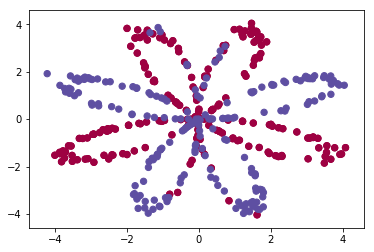

In [4]:
for j in range(2):
    ix = range(N * j, N * (j + 1))
    theta = np.linspace(j * 3.12, (j + 1) * 3.12, N) + np.random.randn(N) * 0.2 #theta
    r = a * np.sin(4 * theta) + np.random.randn(N) * 0.2  #radius
    x[ix] = np.c_[r * np.sin(theta), r * np.cos(theta)]
    y[ix] = j
    plt.scatter(x[:, 0], x[:, 1], c = y.reshape(-1), s = 40, cmap = plt.cm.Spectral)

我们可以先尝试用logistic回归来解决这个问题

In [5]:
x = t.from_numpy(x).float()
y = t.from_numpy(y).float()

In [6]:
w = nn.Parameter(t.randn(2, 1))
b = nn.Parameter(t.zeros(1))

optimizer = t.optim.SGD([w, b], lr = 0.1)
def logistic_regression(x, w, b):
    return t.mm(x, w) + b

criterion = nn.BCEWithLogitsLoss()

In [7]:
for e in range(1000):
    out = logistic_regression(x, w, b)
    loss = criterion(out, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [8]:
def plot_logistic(x):
    x = t.from_numpy(x).float()
    out = t.sigmoid(logistic_regression(x, w, b))
    out = (out > 0.5) * 1
    return out.data.numpy()

Text(0.5,1,'logistic_regression')

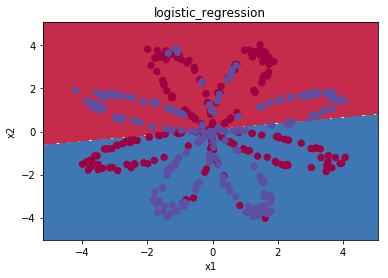

In [9]:
plot_decision_boundary(lambda x:plot_logistic(x), x.numpy(), y.numpy())
plt.title('logistic_regression')

可以看到，logistic回归不能很好地分开这个复杂的数据集，如果你还记得之前的内容，你应该记得logistic回归是一个线性分类器。这时候就该是神经网络出场了！

In [10]:
#定义两层神经网络的参数
w1 = nn.Parameter(t.randn(2, 4) * 0.01) #隐藏层神经元数：2
b1 = nn.Parameter(t.zeros(4))

w2 = nn.Parameter(t.randn(4, 1) * 0.01)
b2 = nn.Parameter(t.zeros(1))

#定义模型
def two_network(x):
    x1 = t.mm(x, w1) + b1
    x1 = t.tanh(x1)
    x2 = t.mm(x1, w2) + b2
    return x2

optimizer = t.optim.SGD([w1, b1, w2, b2], lr = 1.)

criterion = nn.BCEWithLogitsLoss()

In [11]:
for e in range(10000):
    out = two_network(x)
    loss = criterion(out, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 1000 == 0:
        print('epoch:{}, loss:{}'.format(e + 1, loss.data))

epoch:1000, loss:0.2848362326622009
epoch:2000, loss:0.27217793464660645
epoch:3000, loss:0.2650693655014038
epoch:4000, loss:0.26024627685546875
epoch:5000, loss:0.2568076252937317
epoch:6000, loss:0.2542639672756195
epoch:7000, loss:0.25232112407684326
epoch:8000, loss:0.2507965564727783
epoch:9000, loss:0.24957257509231567
epoch:10000, loss:0.24857103824615479


In [12]:
def plot_network(x):
    x = t.from_numpy(x).float()
    x1 = t.mm(x, w1) + b1
    x1 = t.tanh(x1)
    x2 = t.mm(x1, w2) + b2
    out = t.sigmoid(x2)
    out = (out>0.5) * 1
    return out.data.numpy()

Text(0.5,1,'two layers network')

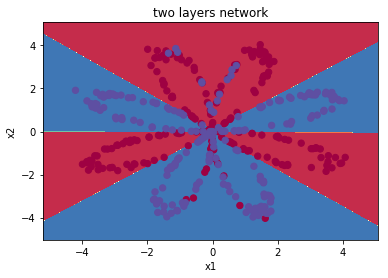

In [13]:
plot_decision_boundary(lambda x:plot_network(x), x.numpy(), y.numpy())
plt.title('two layers network')

可以看到神经网络能够非常好的分类这个复杂的数据，和前面的logistic回归相比，神经网络多了激活函数，成为了非线性分类器，所以分类边界更加复杂

## Sequential 和 Module
我们讲了数据处理，模型构建，loss 函数设计等等内容，但是目前为止我们还没有准备好构建一个完整的机器学习系统，一个完整的机器学习系统需要我们不断地读写模型。在现实应用中，一般我们会将模型在本地进行训练，然后保存模型，接着我们会将模型部署到不同的地方进行应用，所以在这节课我们会教大家如何保存 PyTorch 的模型。

首先我们会讲一下 PyTorch 中的模块，Sequential 和 Module。

对于前面的线性回归模型、 Logistic回归模型和神经网络，我们在构建的时候定义了需要的参数。这对于比较小的模型是可行的，但是对于大的模型，比如100 层的神经网络，这个时候再去手动定义参数就显得非常麻烦，所以 PyTorch 提供了两个模块来帮助我们构建模型，一个是Sequential，一个是 Module。

我们下面分别用 Sequential 和 Module 来定义上面的神经网络。

In [14]:
#Sequential
seq_net = nn.Sequential(
    nn.Linear(2, 4),
    nn.Tanh(),
    nn.Linear(4, 1)
)

In [15]:
#序列模块可以通过索引访问每一层
seq_net[0] #第一层

Linear(in_features=2, out_features=4, bias=True)

In [16]:
#打印出第一层的权重
w0 = seq_net[0].weight
print(w0)

Parameter containing:
tensor([[-0.5927,  0.3370],
        [ 0.7026,  0.4336],
        [ 0.2532, -0.3079],
        [ 0.3604, -0.1870]], requires_grad=True)


In [17]:
#通过parameters可以获得模型的参数
param = seq_net.parameters()

#定义优化器
optimizer = t.optim.SGD(param, lr = 1.)

In [18]:
#训练10000次
for e in range(10000):
    out = seq_net(x)
    loss = criterion(out, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 1000 == 0:
        print('epoch:{}, loss:{}'.format(e + 1, loss.data))

epoch:1000, loss:0.2837672531604767
epoch:2000, loss:0.2716820240020752
epoch:3000, loss:0.26474106311798096
epoch:4000, loss:0.2600148022174835
epoch:5000, loss:0.2566385269165039
epoch:6000, loss:0.2541365325450897
epoch:7000, loss:0.25222229957580566
epoch:8000, loss:0.25071796774864197
epoch:9000, loss:0.24950885772705078
epoch:10000, loss:0.24851837754249573


可以看到，训练 10000 次 loss 比之前的更低，这是因为 PyTorch 自带的模块比我们写的更加稳定，同时也有一些初始化的问题在里面，关于参数初始化，我们会在后面的课程中讲到

In [19]:
def plot_seq(x):
    out = t.sigmoid(seq_net(t.from_numpy(x).float())).data.numpy()
    out = (out > 0.5) * 1
    return out

Text(0.5,1,'Sequential')

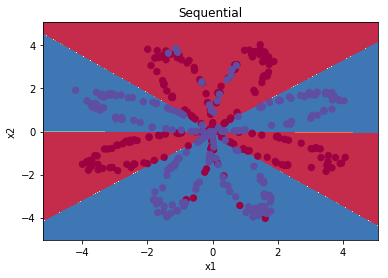

In [20]:
plot_decision_boundary(lambda x: plot_seq(x), x.numpy(), y.numpy())
plt.title('Sequential')

最后我们讲一讲如何保存模型，保存模型在pytorch中有两种方式，一种是将模型结构和参数都保存在一起，一种是只将参数保存下来，下面我们一一介绍。

In [21]:
#将参数和模型保存在一起
t.save(seq_net, 'save_seq_net.pth')

上面就是保存模型的方式，torch.save有两个参数，第一个是保存的1模型，第二个是保存的路径，读取模型的方式也很简单

In [22]:
#读取保存的模型
seq_net1 = t.load('save_seq_net.pth')

In [23]:
seq_net1

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1, bias=True)
)

In [24]:
print(seq_net1[0].weight)

Parameter containing:
tensor([[-10.3142,  12.9247],
        [ 10.0663,  11.7734],
        [ -0.0445,  -7.9418],
        [  0.5563,   2.0012]], requires_grad=True)


我们可以看到，我们重新读取了模型，命名为seq_net1，并且打印了第一层的参数

下面我们看看第二种保存模型的方式：只保存参数，不保存模型结构

In [25]:
#保存模型参数
t.save(seq_net.state_dict(), 'save_seq_net_parameters.pth')

通过上面的方式，我们保存了模型的参数，如果要重新读入参数，首先我们需要重新定义模型，再重新读入参数

In [29]:
seq_net2 = nn.Sequential(
    nn.Linear(2, 4),
    nn.Tanh(),
    nn.Linear(4, 1))
seq_net2.load_state_dict(t.load('save_seq_net_parameters.pth'))

In [30]:
seq_net2

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1, bias=True)
)

In [31]:
print(seq_net2[0].weight)

Parameter containing:
tensor([[-10.3142,  12.9247],
        [ 10.0663,  11.7734],
        [ -0.0445,  -7.9418],
        [  0.5563,   2.0012]], requires_grad=True)


通过这种方式我们也重新读入了相同的参数。

有这样两种保存模型和参数的办法，我们推荐 第二种 ，因为第二种可移植性更强。

下面我们再用Module定义这个模型，下面是Module的模板

```
class 网络名字(nn.Module):
    def __init__(self, 一些定义的参数):
        super(网络名字, self).__init__()
        self.layer1 = nn.Linear(num_input, num_hidden)
        self.layer2 = nn.Sequential(...)
        ...
        
        定义需要用的网络层
        
    def forward(self, x): # 定义前向传播
        x1 = self.layer1(x)
        x2 = self.layer2(x)
        x = x1 + x2
        ...
        return x
```

注意的是，Module 里面也可以使用 Sequential，同时 Module 非常灵活，具体体现在 forward 中，如何复杂的操作都能直观的在 forward 里面执行

下面我们照着模板实现一下上面的神经网络

In [32]:
class module_net(nn.Module):
    def __init__(self, num_input, num_hidden, num_output):
        super(module_net,self).__init__()
        self.layer1 = nn.Linear(num_input, num_hidden)
        self.layer2 = nn.Tanh()
        self.layer3 = nn.Linear(num_hidden, num_output)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [33]:
mo_net = module_net(2, 4, 1)

In [34]:
#访问模型中某层可以直接通过名字
#第一层
l1 = mo_net.layer1
print(l1)

Linear(in_features=2, out_features=4, bias=True)


In [35]:
#打印出第一层的权重
print(l1.weight)

Parameter containing:
tensor([[-0.5849, -0.2993],
        [-0.3741, -0.1779],
        [ 0.3944,  0.5877],
        [-0.4136,  0.3528]], requires_grad=True)


In [36]:
#定义优化器
optimizer = t.optim.SGD(mo_net.parameters(), lr = 1.)

In [37]:
#我们训练10000次
for e in range(10000):
    out = mo_net(x)
    loss = criterion(out, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 1000 == 0:
        print('epoch:{}, loss:{}'.format(e + 1, loss.data))

epoch:1000, loss:0.2836589813232422
epoch:2000, loss:0.27161797881126404
epoch:3000, loss:0.2646975815296173
epoch:4000, loss:0.25998514890670776
epoch:5000, loss:0.25661778450012207
epoch:6000, loss:0.2541215419769287
epoch:7000, loss:0.25221118330955505
epoch:8000, loss:0.2507093548774719
epoch:9000, loss:0.24950212240219116
epoch:10000, loss:0.24851295351982117


In [38]:
#保存模型
t.save(mo_net.state_dict(), 'module_net.pth')

可以看到我们得到了相同的结果，而且使用 Sequential 和 Module 来定义模型更加方便

在这一节中我们还是使用梯度下降法来优化参数，在神经网络中，这种优化方法有一个特别的名字，反向传播算法，下一次课我们会讲一讲什么是反向传播算法

**小练习：改变网络的隐藏层神经元数目，或者试试定义一个 5 层甚至更深的模型，增加训练次数，改变学习率，看看结果会怎么样**

In [40]:
net = nn.Sequential(
    nn.Linear(2, 10),
    nn.Tanh(),
    nn.Linear(10, 10),
    nn.Tanh(),
    nn.Linear(10, 10),
    nn.Tanh(),
    nn.Linear(10, 10),
    nn.Tanh(),
    nn.Linear(10, 1)
)

optimizer = t.optim.SGD(net.parameters(), 0.1)

In [41]:
for e in range(20000):
    out = net(x)
    loss = criterion(out, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 1000 == 0:
        print('epoch:{}, loss:{}'.format(e + 1, loss.data))

epoch:1000, loss:0.2897002100944519
epoch:2000, loss:0.2129203826189041
epoch:3000, loss:0.19453009963035583
epoch:4000, loss:0.18507567048072815
epoch:5000, loss:0.17521871626377106
epoch:6000, loss:0.16009660065174103
epoch:7000, loss:0.15294039249420166
epoch:8000, loss:0.14910608530044556
epoch:9000, loss:0.14562863111495972
epoch:10000, loss:0.14481119811534882
epoch:11000, loss:0.14011149108409882
epoch:12000, loss:0.1383959949016571
epoch:13000, loss:0.14116357266902924
epoch:14000, loss:0.13766475021839142
epoch:15000, loss:0.13380299508571625
epoch:16000, loss:0.13190802931785583
epoch:17000, loss:0.14413368701934814
epoch:18000, loss:0.18155954778194427
epoch:19000, loss:0.12350782752037048
epoch:20000, loss:0.11869068443775177


In [42]:
def plot_net(x):
    out = t.sigmoid(net(t.from_numpy(x).float())).data.numpy()
    out = (out > 0.5) * 1
    
    return out

Text(0.5,1,'sequential')

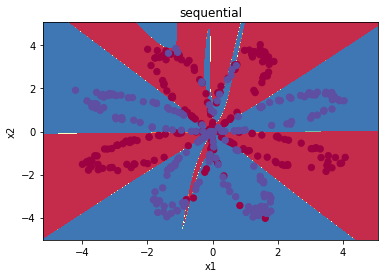

In [43]:
plot_decision_boundary(lambda x:plot_net(x), x.numpy(), y.numpy())
plt.title('sequential')

下面用Module来试试

In [64]:
class five_layers_network(nn.Module):
    def __init__(self, num_input, num_hidden1, num_hidden2, num_hidden3, num_hidden4, num_output):
        super(five_layers_network, self).__init__()
        self.layer1 = nn.Linear(num_input, num_hidden1)
        self.layer2 = nn.Tanh()
        self.layer3 = nn.Linear(num_hidden1, num_hidden2)
        self.layer4 = nn.Tanh()
        self.layer5 = nn.Linear(num_hidden2, num_hidden3)
        self.layer6 = nn.Tanh()
        self.layer7 = nn.Linear(num_hidden3, num_hidden4)
        self.layer8 = nn.Tanh()
        self.layer9 = nn.Linear(num_hidden4, num_output)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        return x

In [65]:
module_net1 = five_layers_network(2, 10, 10, 10, 10, 1)

In [66]:
optimizer = t.optim.SGD(module_net1.parameters(), lr = 0.1)

In [67]:
for e in range(20000):
    out = module_net1(x)
    loss = criterion(out, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 1000 == 0:
        print('epoch:{}, loss:{}'.format(e + 1, loss.data))

epoch:1000, loss:0.26927319169044495
epoch:2000, loss:0.22637246549129486
epoch:3000, loss:0.20657728612422943
epoch:4000, loss:0.19420309364795685
epoch:5000, loss:0.18456511199474335
epoch:6000, loss:0.17663729190826416
epoch:7000, loss:0.1690075844526291
epoch:8000, loss:0.16096054017543793
epoch:9000, loss:0.15371309220790863
epoch:10000, loss:0.1466907411813736
epoch:11000, loss:0.14309220016002655
epoch:12000, loss:0.13979250192642212
epoch:13000, loss:0.13756664097309113
epoch:14000, loss:0.135928213596344
epoch:15000, loss:0.13460491597652435
epoch:16000, loss:0.13342003524303436
epoch:17000, loss:0.1322595626115799
epoch:18000, loss:0.13102158904075623
epoch:19000, loss:0.12640179693698883
epoch:20000, loss:0.1253172904253006


In [68]:
def plot_module_net(x):
    out = t.sigmoid(module_net1(t.from_numpy(x).float())).data.numpy()
    out = (out > 0.5) * 1
    return out

Text(0.5,1,'Module')

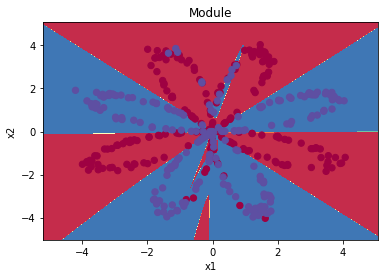

In [69]:
plot_decision_boundary(lambda x:plot_module_net(x), x.numpy(), y.numpy())
plt.title('Module')